To work on:
Axes labels to the plots
Small z range
Implement callbacks, weights saving, predictions saving, ...

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from DataMaker import *

In [2]:
LATENT_DIM = 128
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
EPOCHS = 100
GB_LIMIT = 10
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: between 1e-6 and 1e-7

In [3]:
DATASET_NAME = "HSC_v6_small"
MODEL_TYPE = "VAE"
MODEL_VERSION = "v8"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)
weights_file = dir_model + '/weights.h5'

print(weights_file)
print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

/models/HSC_v6_small_VAE_v8/model/weights.h5
/models/HSC_v6_small_VAE_v8/model
/models/HSC_v6_small_VAE_v8/checkpoints
/logs/HSC_v6_small_VAE_v8
/predictions/HSC_v6_small_VAE_v8


## Allocate GPU

Make sure to check others' current usage on Aurora in terminal using `watch nvidia-smi`. Set your `GB_LIMIT` accordingly, in gigabytes. Aurora has 50GB of memory.

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT* 2000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2022-11-09 19:23:53.751226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-11-09 19:23:53.763345: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 19:23:53.764435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 19:23:53.766916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-09 19:23:53.768632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Data

Create the shuffled and batched data generators.

from albumentations import Compose
from albumentations.augmentations.transforms import ToFloat

my_augmenter = Compose([ToFloat(max_value=4.16)])
batch_args_gen = {'X_key': 'image', 'y_key': 'image', 'labels_encoding': False, 'scaler': False,
                  'batch_size': BATCH_SIZE, 'mode': 'train', 'shuffle': True}
args_gen = {'X_key': 'image', 'y_key': 'image', 'labels_encoding': False, 'scaler': False,
            'batch_size': 1, 'mode': 'test', 'shuffle': False}
start_path = "/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_"
TRAIN_PATH = start_path + "training_small.hdf5"
VAL_PATH = start_path + "validation_small.hdf5"
TEST_PATH = start_path + "testing_small.hdf5"

train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **batch_args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **batch_args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [5]:
hf_train = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training_small.hdf5', 'r')
hf_test = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing_small.hdf5', 'r')
hf_validation = h5py.File('/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation_small.hdf5', 'r')
x_train = np.asarray(hf_train['image'][0:])
x_test = np.asarray(hf_test['image'][0:])
x_validation = np.asarray(hf_validation['image'][0:])
max_value = 4.16
x_train = np.true_divide(x_train, max_value)
x_test = np.true_divide(x_test, max_value)
x_validation = np.true_divide(x_validation, max_value)
y_train = np.asarray(hf_train['specz_redshift'][0:])[..., None]
y_test = np.asarray(hf_test['specz_redshift'][0:])[..., None]
y_validation = np.asarray(hf_validation['specz_redshift'][0:])[..., None]
# object_id_train = np.asarray(hf_train['object_id'][0:])
# object_id = np.asarray(hf_test['object_id'][0:])
# object_id_validation = np.asarray(hf_validation['object_id'][0:])
hf_train.close()
hf_test.close()
hf_validation.close()

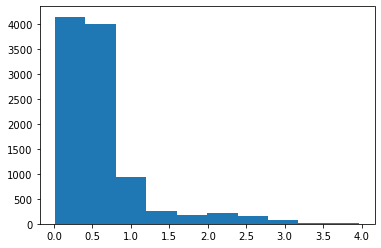

In [6]:
plt.hist(y_train)
plt.show()

for i in range(0,10000):
    if y_train[i]>=0.1:
        np.delete(x_train, i)
        np.delete(y_train, i)
for i in range(0,2000):
    if y_test[i]>=0.1:
        np.delete(x_test, i)
        np.delete(y_test, i)
for i in range(0,2000):
    if y_validation[i]>=0.1:
        np.delete(x_validation, i)
        np.delete(y_validation, i)

## Callbacks

What we'd like to save during training.

- Metrics logs per epoch to visualise in TensorBoard.
- Model weights per epoch.
- Predictions and corresponding metrics per prediction per epoch.

An alternative to ReduceLROnPlateau is LearningRateScheduler to decrease step size after a fixed number of epochs, but I think we'd prefer to do it by metric.

In [7]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )
LR_callback = ReduceLROnPlateau()

## VAE Model

### Define model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu

prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims=1)

class VAE(Model):
    def __init__(self):
        super(VAE, self).__init__()
        
        images = Input(shape=IMAGE_SHAPE)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(images)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Conv2D(8, 3, strides=1, activation=leaky_relu,
                   padding='same', data_format='channels_first')(x)
        x = Flatten()(x)
        x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation=None)(x)
        z = tfpl.MultivariateNormalTriL(LATENT_DIM,
                  activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)
        self.encoder = Model(images, z, name='encoder')

        latents = Input(shape=LATENT_DIM)
        x = Dense(4*LATENT_DIM*32*32, activation=None)(latents)
        x = Reshape((4*LATENT_DIM,32,32))(x)
        x = Conv2DTranspose(8, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=2, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2DTranspose(BASE_DEPTH, 3, strides=1, activation=leaky_relu,
                            padding='same', data_format='channels_first')(x)
        x = Conv2D(IMAGE_SHAPE[0], 3, strides=1, activation=None, 
                   padding='same', data_format='channels_first')(x)
        outputs = Cropping2D(cropping=((0,1),(0,1)), data_format='channels_first')(x)
        self.decoder = Model(latents, outputs, name='decoder')

    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def summary(self):
        print(self.encoder.summary())
        print(self.decoder.summary())

In [9]:
model = VAE()

In [10]:
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 127, 127)]     0         
                                                                 
 conv2d (Conv2D)             (None, 8, 127, 127)       368       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 64, 64)         584       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 32, 32)         584       
                                                                 
 flatten (Flatten)           (None, 8192)              0   

### Train model

In [12]:
history = model.fit(
    x = x_train,
    y = x_train,
    epochs = 200,
    callbacks=[logs_callback, weights_callback, LR_callback, tensorboard_callback],
    validation_data = (x_validation, x_validation),
    verbose=2)

2022-11-09 19:24:33.778096: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-11-09 19:24:35.028544: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-11-09 19:24:36.171390: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.
2022-11-09 19:24:36.993711: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3225800000 exceeds 10% of free system memory.


Epoch 1/200


2022-11-09 19:26:42.274160: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-11-09 19:29:26.641447: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-09 19:29:27.105195: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 - 457s - loss: 0.1708 - val_loss: 0.1436 - lr: 0.0010 - 457s/epoch - 1s/step
Epoch 2/200
313/313 - 53s - loss: 0.1425 - val_loss: 0.1386 - lr: 0.0010 - 53s/epoch - 169ms/step
Epoch 3/200
313/313 - 51s - loss: 0.1380 - val_loss: 0.1362 - lr: 0.0010 - 51s/epoch - 162ms/step
Epoch 4/200
313/313 - 55s - loss: 0.1374 - val_loss: 0.1362 - lr: 0.0010 - 55s/epoch - 176ms/step
Epoch 5/200
313/313 - 49s - loss: 0.1322 - val_loss: 0.1343 - lr: 0.0010 - 49s/epoch - 156ms/step
Epoch 6/200
313/313 - 53s - loss: 0.1311 - val_loss: 0.1324 - lr: 0.0010 - 53s/epoch - 168ms/step
Epoch 7/200
313/313 - 50s - loss: 0.1323 - val_loss: 0.1335 - lr: 0.0010 - 50s/epoch - 160ms/step
Epoch 8/200
313/313 - 55s - loss: 0.1301 - val_loss: 0.1391 - lr: 0.0010 - 55s/epoch - 174ms/step
Epoch 9/200
313/313 - 50s - loss: 0.1286 - val_loss: 0.1340 - lr: 0.0010 - 50s/epoch - 160ms/step
Epoch 10/200
313/313 - 46s - loss: 0.1235 - val_loss: 0.1349 - lr: 0.0010 - 46s/epoch - 147ms/step
Epoch 11/200
313/313 - 43s - los

313/313 - 54s - loss: 0.0652 - val_loss: 0.0985 - lr: 1.0000e-04 - 54s/epoch - 173ms/step
Epoch 84/200
313/313 - 50s - loss: 0.0654 - val_loss: 0.1012 - lr: 1.0000e-04 - 50s/epoch - 160ms/step
Epoch 85/200
313/313 - 53s - loss: 0.0644 - val_loss: 0.1004 - lr: 1.0000e-04 - 53s/epoch - 169ms/step
Epoch 86/200
313/313 - 50s - loss: 0.0642 - val_loss: 0.0996 - lr: 1.0000e-04 - 50s/epoch - 159ms/step
Epoch 87/200
313/313 - 54s - loss: 0.0639 - val_loss: 0.1012 - lr: 1.0000e-04 - 54s/epoch - 171ms/step
Epoch 88/200
313/313 - 50s - loss: 0.0638 - val_loss: 0.0984 - lr: 1.0000e-04 - 50s/epoch - 160ms/step
Epoch 89/200
313/313 - 54s - loss: 0.0614 - val_loss: 0.0990 - lr: 1.0000e-04 - 54s/epoch - 174ms/step
Epoch 90/200
313/313 - 51s - loss: 0.0619 - val_loss: 0.0990 - lr: 1.0000e-05 - 51s/epoch - 162ms/step
Epoch 91/200
313/313 - 52s - loss: 0.0632 - val_loss: 0.0994 - lr: 1.0000e-05 - 52s/epoch - 167ms/step
Epoch 92/200
313/313 - 50s - loss: 0.0625 - val_loss: 0.0972 - lr: 1.0000e-05 - 50s/ep

313/313 - 58s - loss: 0.0601 - val_loss: 0.0995 - lr: 1.0000e-09 - 58s/epoch - 186ms/step
Epoch 163/200
313/313 - 56s - loss: 0.0611 - val_loss: 0.0971 - lr: 1.0000e-09 - 56s/epoch - 180ms/step
Epoch 164/200
313/313 - 65s - loss: 0.0602 - val_loss: 0.0974 - lr: 1.0000e-10 - 65s/epoch - 208ms/step
Epoch 165/200
313/313 - 58s - loss: 0.0607 - val_loss: 0.1001 - lr: 1.0000e-10 - 58s/epoch - 185ms/step
Epoch 166/200
313/313 - 57s - loss: 0.0593 - val_loss: 0.0967 - lr: 1.0000e-10 - 57s/epoch - 182ms/step
Epoch 167/200
313/313 - 51s - loss: 0.0614 - val_loss: 0.0990 - lr: 1.0000e-10 - 51s/epoch - 162ms/step
Epoch 168/200
313/313 - 59s - loss: 0.0602 - val_loss: 0.0980 - lr: 1.0000e-10 - 59s/epoch - 190ms/step
Epoch 169/200
313/313 - 56s - loss: 0.0589 - val_loss: 0.0963 - lr: 1.0000e-10 - 56s/epoch - 179ms/step
Epoch 170/200
313/313 - 63s - loss: 0.0594 - val_loss: 0.0962 - lr: 1.0000e-10 - 63s/epoch - 203ms/step
Epoch 171/200
313/313 - 59s - loss: 0.0603 - val_loss: 0.1003 - lr: 1.0000e-10

### Save final model

In [31]:
model.save_weights(weights_file)

## Save final predictions

In [14]:
from sys import stdout
from time import sleep

In [15]:
def save_preds(dataset='train', num_to_save=None):
    if dataset == 'train':
        datagen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
    elif dataset == 'val':
        datagen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
    else:
        dataset = 'test'
        datagen = test_gen
    preds_path = os.path.join(dir_predictions, dataset + "_preds.hdf5")
    print("Saving predictions for", dataset, "dataset in", preds_path)
    
    if num_to_save is None:
        size = len(datagen._indices)
    else:
        size = num_to_save

    with h5py.File(preds_path, 'w') as f:
        f.create_dataset('true', (size, ) + IMAGE_SHAPE)
        f.create_dataset('pred', (size, ) + IMAGE_SHAPE)
        f.create_dataset('loss', size)
        it = iter(datagen)
        for i in range(size):
            x = next(it)
            f['true'][i] = x
            f['pred'][i] = model.predict(x, verbose=0)
            f['loss'][i] = model.evaluate(x, x, verbose=0)
            stdout.write("\rSaved %d samples of " % i + str(size))
            stdout.flush()
            i += 1

In [16]:
# save_preds('train')

In [17]:
# save_preds('val')

In [18]:
# save_preds('test')

def display_preds(dataset='train', num_to_show=10):
    preds_path = os.path.join(dir_predictions, dataset + "_preds.hdf5")    
    with h5py.File(preds_path, 'r') as f:
        fig, axes = plt.subplots(nrows=num_to_show, ncols=2, figsize=(10,5*num_to_show))
        for i in range(num_to_show):
            axes[i][0].imshow(np.array([x_test[i]])[0][1])
            axes[i][0].set_title('True')
            axes[i][1].imshow(model(np.array([x_test[i]]))[0][1])
            axes[i][1].set_title("Pred, loss %.2f" % f['loss'][i])

In [19]:
def scatter_bands(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([x_test[i]])[0][j]))
            pred_array = np.append(pred_array, np.amax(model(np.array([x_test[i]]))[0][j]))
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel("Bands")
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index)/5)][int((i - index)%5)].legend()

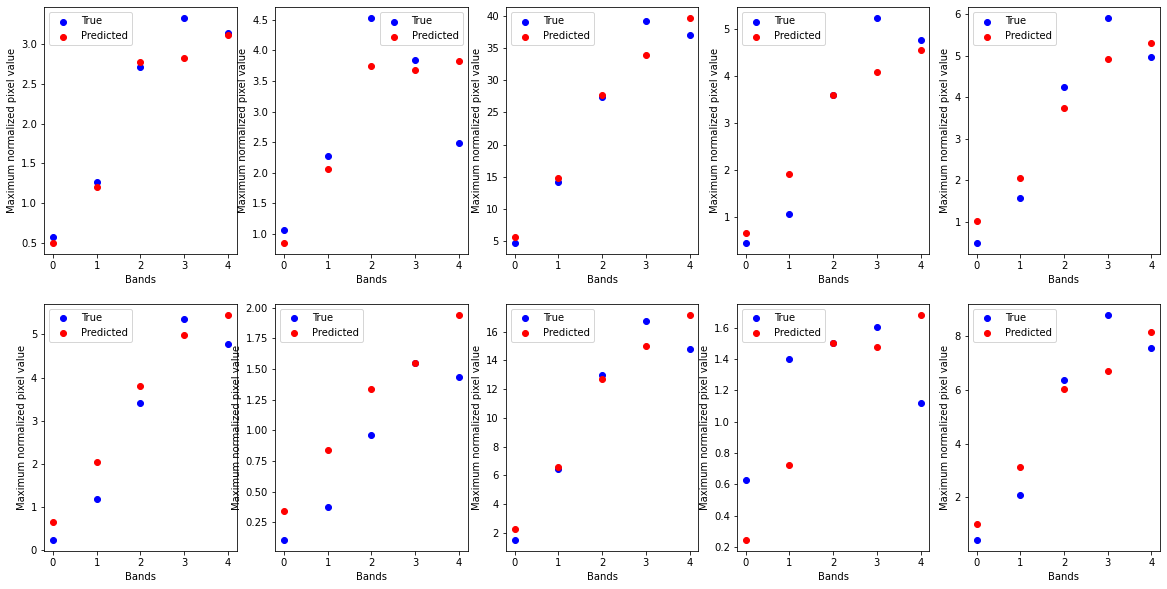

In [20]:
scatter_bands()

In [21]:
def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([x_test[i]])[0][j].flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

In [22]:
def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([x_test[i]])[0][j].flatten())
            pred_mean = np.mean(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index)/5)][int((i - index)%5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index)/5)][int((i - index)%5)].set_xlabel('Bands')
        axes[int((i - index)/5)][int((i - index)%5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index)/5)][int((i - index)%5)].legend()

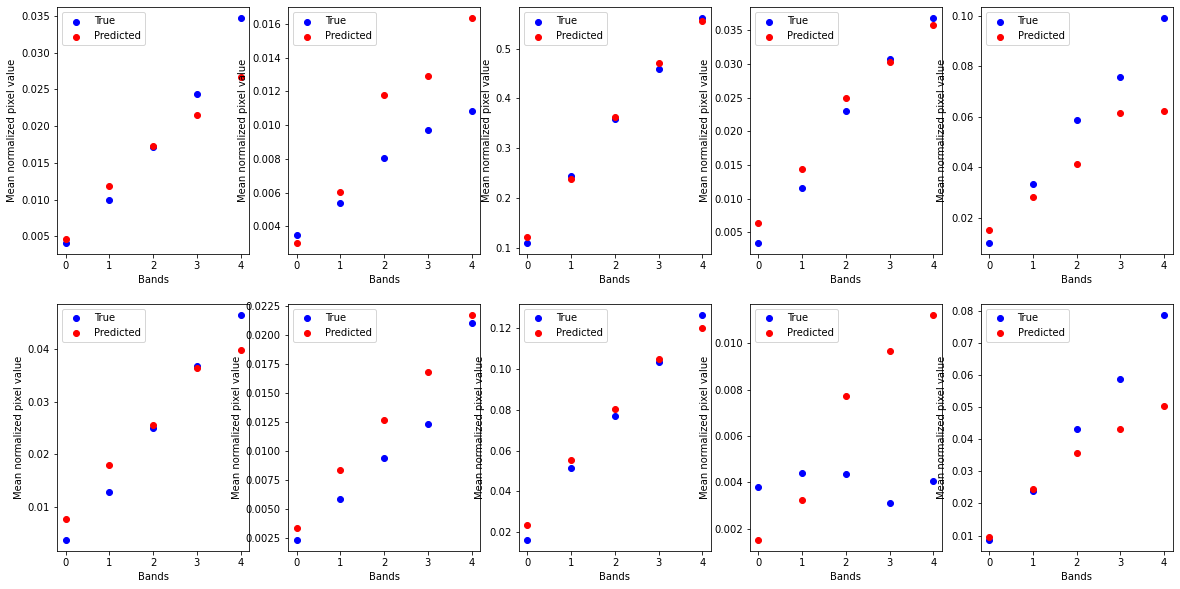

In [23]:
scatter_bands_mean(10, 0)

scatter_bands_percentile(50, 10, 0)

In [24]:
def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 10))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([x_test[i]])[0][j].flatten())
            pred_arr = sorted(np.asarray(model(np.array([x_test[i]]))[0][j]).flatten())
            true_arr = true_arr[0:int(len(true_arr)*.99)]
            pred_arr = pred_arr[0:int(len(pred_arr)*.99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha=0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha=0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')

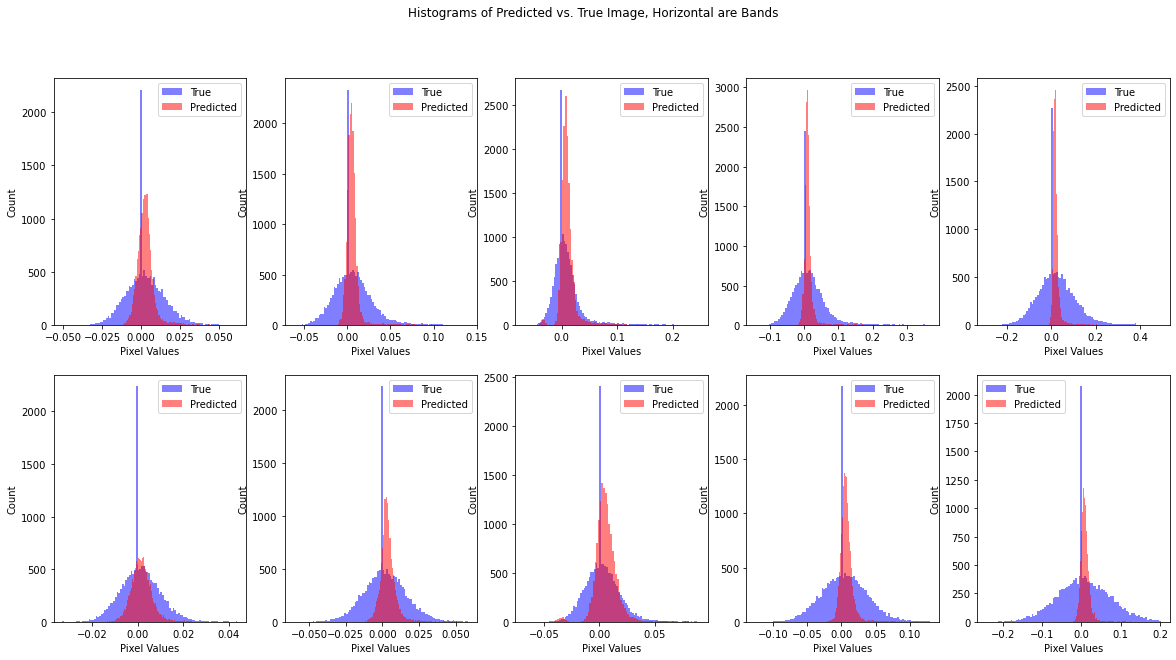

In [25]:
display_histograms()

In [26]:
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    for i in range(0, 5):
        axes[0][i].imshow(np.array([x_test[index]])[0][i])
        max_pixel_true = round(np.amax(np.array([x_test[index]])[0][i]), 2)
        axes[0][i].set_title(f'True band {i} max = ' + str(max_pixel_true))
        pred = model(np.array([x_test[index]]))[0][i]
        axes[1][i].imshow(pred)
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'Pred band {i} max = ' + str(max_pixel_pred))

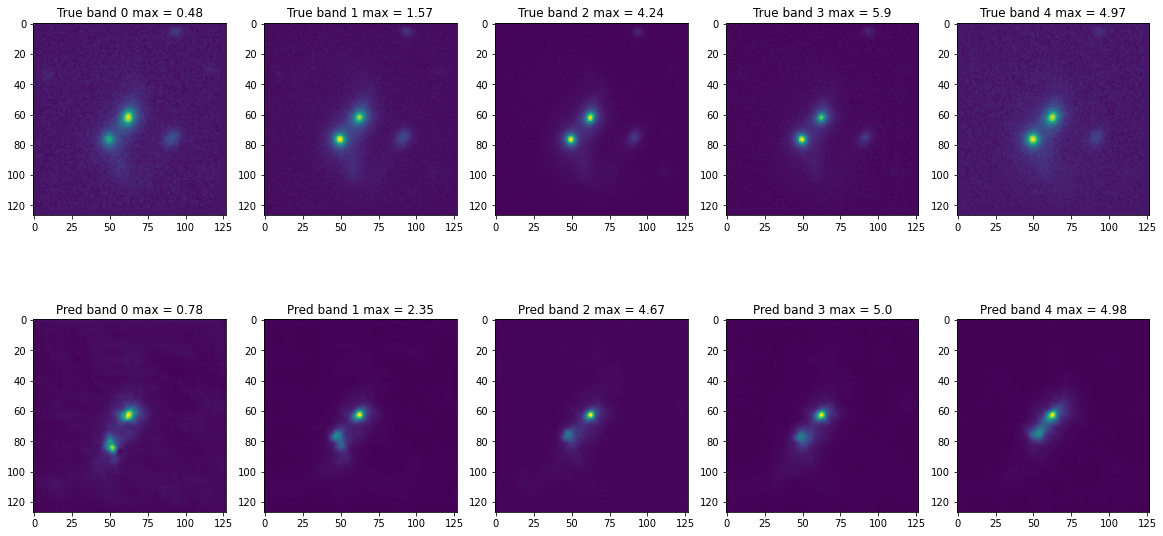

In [27]:
display_5_bands(4)

display_preds('val', num_to_show=10)

### Example generations

In [28]:
from matplotlib import gridspec
import math

def generate_example_galaxies(num_to_generate=10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    cols = 3
    rows = int(math.ceil(num_to_generate / cols))
    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(15, 5*rows))
    for i in range(num_to_generate):
        ax = fig.add_subplot(gs[i])
        ax.imshow(xhat[i][0])
        ax.set_title(f'Generated image {i}')

In [29]:
def generate_example_galaxies(num_to_generate = 10):
    z = prior.sample(num_to_generate)
    xhat = model.decoder(z)
    fig, axes = plt.subplots(nrows = num_to_generate, ncols = 5, figsize = (4 * 5, 4 * num_to_generate))
    for i in range(num_to_generate):
        for j in range(0,5):
            axes[i][j].imshow(xhat[i][j])
            axes[i][j].set_title(f'Generated image {i} band {j}')

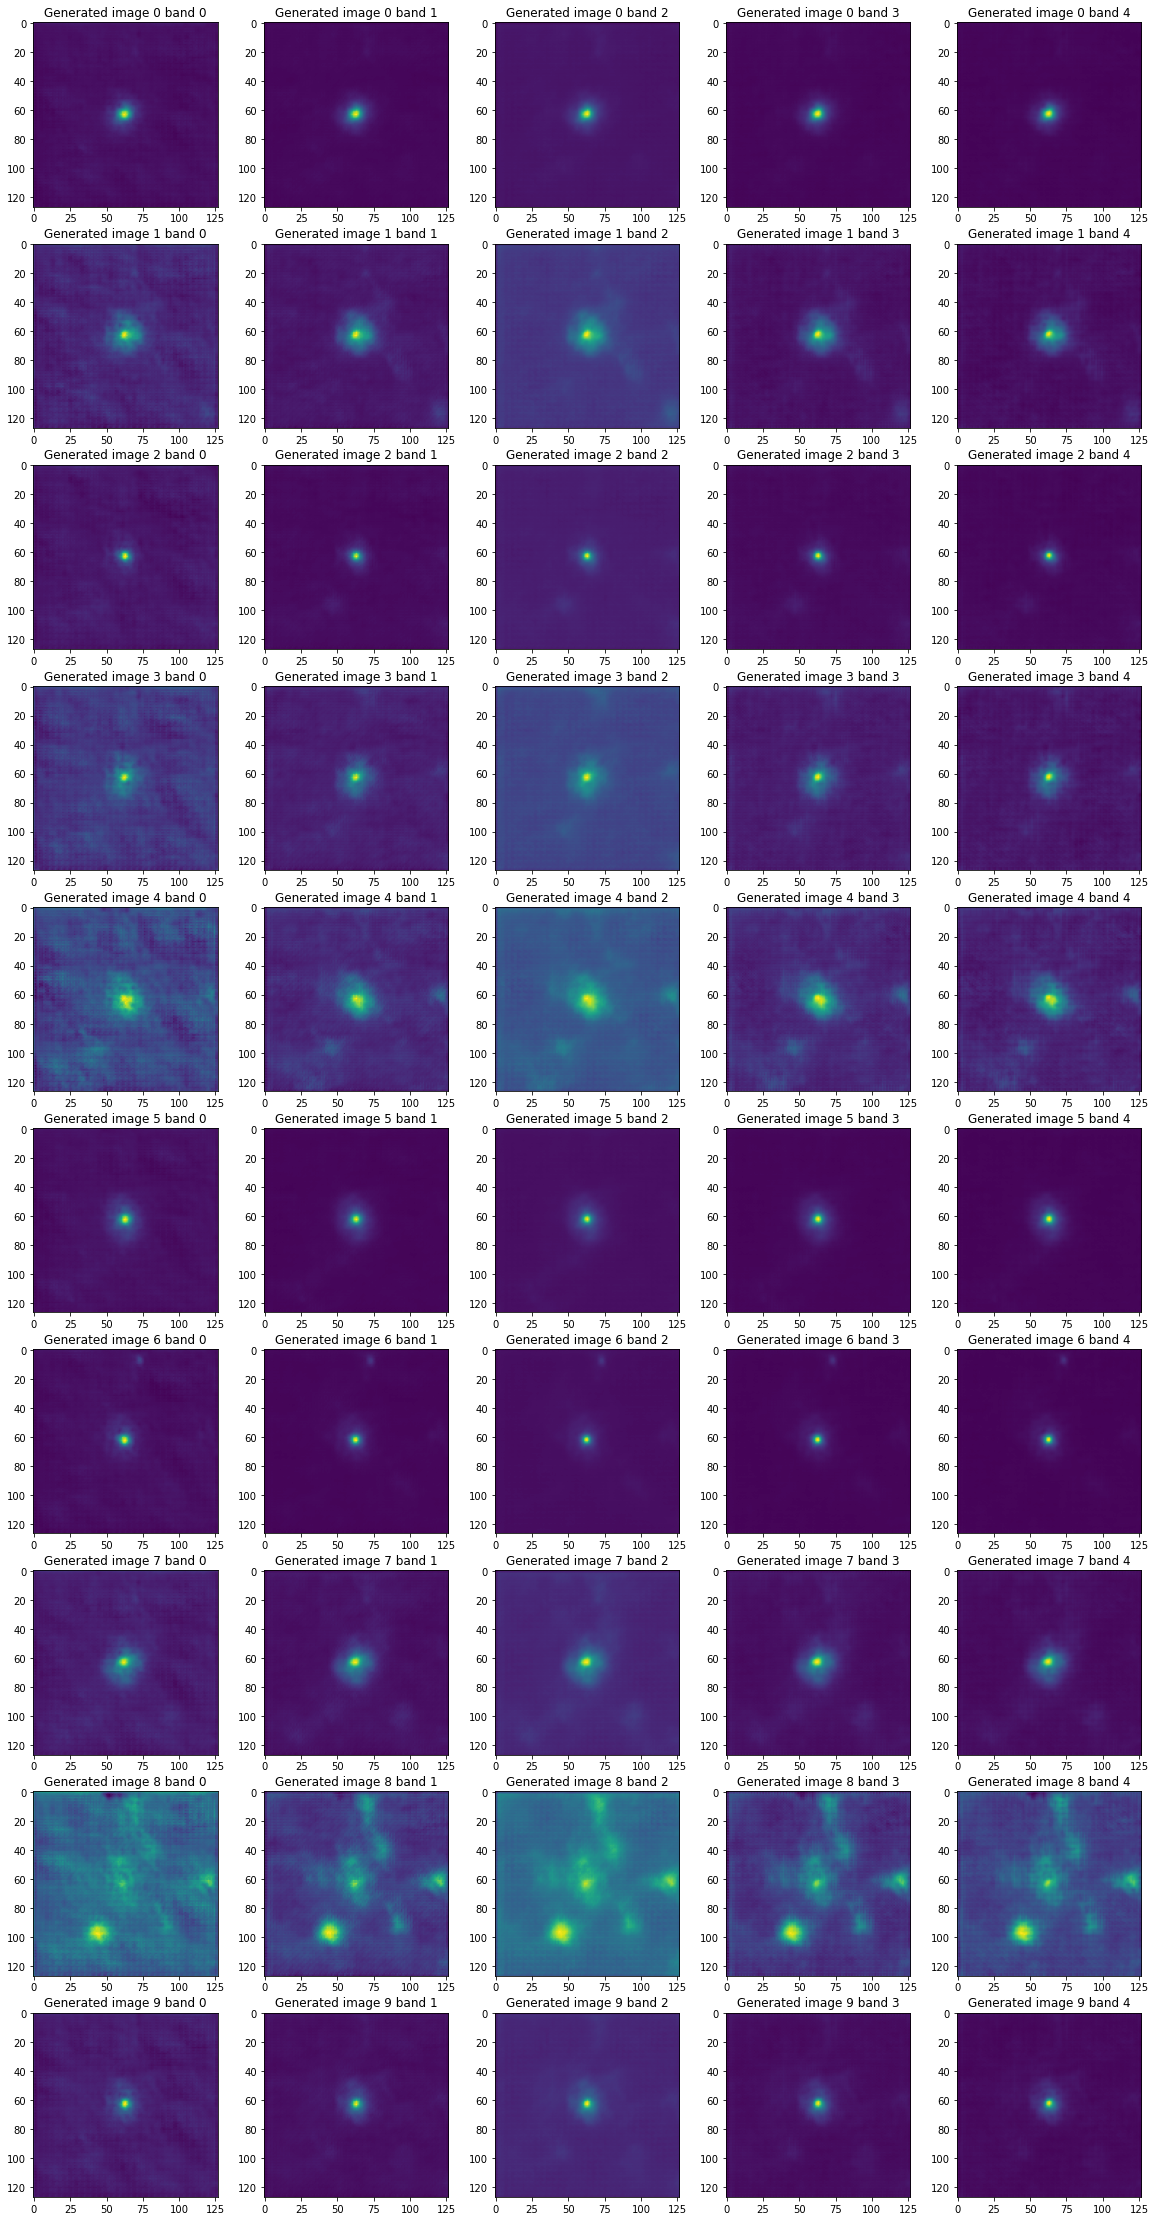

In [30]:
generate_example_galaxies(10)